In [1]:
import numpy as np
from matplotlib import pyplot as plt
import h5py

In [13]:
# some utility functions

def bandpass_extents(B, lam_c):
    Dlam = B*lam_c/(1+B*0.5)
    lam_min = lam_c - 0.5*Dlam
    lam_max = lam_c + 0.5*Dlam
    return lam_min, lam_max, Dlam

def bandpass_extents_end(B, lam_1):
    lam_0 = lam_1/(1+B)
    return  lam_0

def read_raw(file):
    f = open(file,'r')
    lines = f.readlines()
    f.close()

    out = {}
    keys = ['wv','dwv','albedo','flux_ratio']
    nw = len(lines)-1
    for key in keys:
        out[key] = np.empty(nw)

    for i,line in enumerate(lines[1:]):
        tmp = line.strip().split('|')[1:-1]
        tmp = [a.strip() for a in tmp]

        for j,key in enumerate(keys):
            out[key][i] = float(tmp[j])
    return out

def read_dat(file):
    f = open(file,'r')
    lines = f.readlines()
    f.close()

    out = {}
    keys = ['wv','dwv','albedo','flux_ratio','data','uncertainty']
    nw = len(lines)-1
    for key in keys:
        out[key] = np.empty(nw)

    for i,line in enumerate(lines[1:]):
        tmp = line.strip().split('|')[1:-1]
        tmp = [a.strip() for a in tmp]

        for j,key in enumerate(keys):
            out[key][i] = float(tmp[j])
    return out

In [14]:
folder = "NA_rfast/plots/"
filenames = \
[
    "NominalArchean_noCH4.raw",
    "NominalArchean_noCO2.raw",
    "NominalArchean_noH2O.raw",
]
species = ['CH4','CO2','H2O']
plot_species = ['CH4','CO2','H2O']
labels = ['CH$_4$','CO$_2$','H$_2$O']
colors = ['C1','C2','C0']

data = {}
data['all'] = read_raw(folder+"NominalArchean.raw")
for i in range(len(species)):
    data[species[i]] = read_raw(folder+filenames[i])
    
noise = read_dat("NA_rfast/test/test_n.dat")

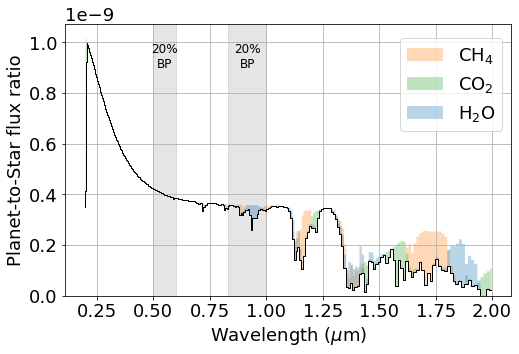

In [18]:
plt.rcParams.update({'font.size': 18})
fig,ax = plt.subplots(1,1,figsize=[8,5])
fig.patch.set_facecolor("w")

ax.plot(data['all']['wv'],data['all']['flux_ratio'], drawstyle='steps-mid',c='k',lw=1,zorder=500)

for i,sp in enumerate(plot_species):
    ax.fill_between(data[sp]['wv'],data['all']['flux_ratio'],data[sp]['flux_ratio'],lw=0,step='mid',color=colors[i],alpha=.3, label=labels[i])


ax.set_xlim(ax.get_xlim()[0],ax.get_xlim()[1])
ax.set_ylim(0,ax.get_ylim()[1])

# ax.set_xlim(.7,1.2)
# ax.set_ylim(.1e-9,.6e-9)



ax.set_ylabel('Planet-to-Star flux ratio')
ax.set_xlabel('Wavelength ($\mu$m)')
ax.legend(ncol=1,bbox_to_anchor=(1,0.98),loc='upper right')
ax.grid()

B = 0.20
lam_max = 1
lam_min = bandpass_extents_end(B, lam_max)
ax.fill_between([lam_min,lam_max],[0,0],[1,1],color='k',alpha=.1)
ax.fill_between([0.5,0.6],[0,0],[1,1],color='k',alpha=.1)
ax.text(np.mean([lam_min,lam_max]), 1e-9, '20%\nBP', \
        size = 12, ha='center', va='top',color='k')
ax.text(.55, 1e-9, '20%\nBP', \
        size = 12, ha='center', va='top',color='k')



# ax.set_xticks([.7,.8,.86,.93,1,1.1])
# lam_1 = 1

# ax.axvline(lam_0,c='k')
# ax.axvline(lam_1,c='k')

# plt.savefig('figures/absorbers.png',dpi=300,bbox_inches='tight')

plt.show()

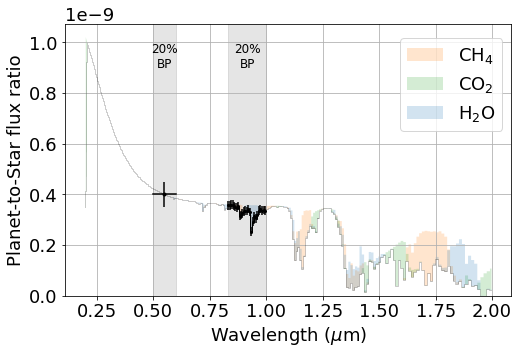

In [23]:
plt.rcParams.update({'font.size': 18})
fig,ax = plt.subplots(1,1,figsize=[8,5])
fig.patch.set_facecolor("w")

alpha = 0.2
ax.plot(data['all']['wv'],data['all']['flux_ratio'], drawstyle='steps-mid',c='k',lw=1,zorder=500,alpha=alpha)
for i,sp in enumerate(plot_species):
    ax.fill_between(data[sp]['wv'],data['all']['flux_ratio'],data[sp]['flux_ratio'],lw=0,step='mid',color=colors[i],alpha=alpha, label=labels[i])

ax.set_ylim(0,ax.get_ylim()[1])
ax.set_xlim(ax.get_xlim()[0],ax.get_xlim()[1])
ax.set_ylabel('Planet-to-Star flux ratio')
ax.set_xlabel('Wavelength ($\mu$m)')
ax.legend(ncol=1,bbox_to_anchor=(1,0.98),loc='upper right')
ax.grid()

ax.fill_between([lam_min,lam_max],[0,0],[1,1],color='k',alpha=.1)
ax.fill_between([0.5,0.6],[0,0],[1,1],color='k',alpha=.1)
ax.text(np.mean([lam_min,lam_max]), 1e-9, '20%\nBP', \
        size = 12, ha='center', va='top',color='k')
ax.text(.55, 1e-9, '20%\nBP', \
        size = 12, ha='center', va='top',color='k')


# error bars
ax.plot([noise['wv'][0]-noise['dwv'][0],noise['wv'][0]+noise['dwv'][0]]\
        ,[noise['data'][0],noise['data'][0]],c='k')
ax.errorbar(noise['wv'][:1],noise['data'][:1],noise['uncertainty'][:1],c='k',ms=3,fmt='o',drawstyle='steps-mid')

ax.plot(noise['wv'][2:],noise['flux_ratio'][2:], drawstyle='steps-mid',c='k',lw=1,zorder=500)
ax.errorbar(noise['wv'][2:],noise['data'][2:],noise['uncertainty'][2:],c='k',ms=2,fmt='o',drawstyle='steps-mid')

plt.savefig('figures/noise_example.png',dpi=300,bbox_inches='tight')

plt.show()

In [21]:
lam_min

0.8333333333333334

# Retrievals

In [7]:
def make_input_lists(B_1, res_1, snr_1):
    B = []
    res = []
    snr = []
    for b in B_1:
        for r in res_1:
            for s in snr_1:
                B.append(b)
                res.append(r)
                snr.append(s)
    return B,res,snr

def get_filenames(root_outdir, prefix, B, res, snr):
    fns_name = \
    prefix+"_"+('B=%.4f'%B)+"_"+('res=%.4f'%res)+"_"+('snr=%.4f'%snr)
    h5file = root_outdir+'/'+fns_name+'/'+fns_name+'_r.h5'

    return h5file

In [53]:
f = open('NA_rfast/NominalArchean.atm','r')
lines = f.readlines()
f.close

atm = {}
keys = lines[0].strip().split()
for key in keys:
    atm[key] = np.empty(len(lines[1:]))
for j,line in enumerate(lines[1:]):
    for i,key in enumerate(keys):
        atm[key][j] = float(line.strip().split()[i])

atm['pressure'] = atm['pressure']/1e5
for key in keys:
    if key != 'temperature' and key != 'pressure':
        atm[key] = np.log10(atm[key])

In [142]:
root_outdir = "../results/NominalArcheanResults"
prefix = "MA"
B_1 = [0.15, 0.2]
res_1 = [70, 140]
snr_1 = [5, 10, 15, 20] 

LN2 = 0
LO2 = 1
LH2O = 2
LCO2 = 3
LO3 = 4
LCO = 5
LCH4 = 6
LH2 = 7
LP0 = 8
LAs = 9
LRp = 10
Lg = 11
Ldpc = 12
Lpt = 13
Ltauc0 = 14
Lfc = 15
sp_params = ['N2','O2','H2O','CO2','O3','CO','CH4','H2'] #,'P0','As','Rp','g','dpc','pt','tauc0','fc']
params = ['N2','O2','H2O','CO2','O3','CO','CH4','H2','P0','As','Rp','g','dpc','pt','tauc0','fc']

In [180]:
nburn = 1000
edges = np.arange(-10,0.1,0.2)

sol = {}

for b in B_1:
    sol[b] = {}
    for r in res_1:
        sol[b][r] = {}
        for s in snr_1:
            sol[b][r][s] = {}
            
            file = get_filenames(root_outdir, prefix, b, r, s)
            with h5py.File(file, 'r') as f:
                chain = f['mcmc']['chain'][:,:,:] 
            chain = chain[nburn:,:,:]
            chain = chain.reshape(chain.shape[0]*chain.shape[1],chain.shape[2])
            
            for i,p in enumerate(params):
                sol[b][r][s][p] = {}
                if p in sp_params:
                    hist, bin_edges = np.histogram(chain[:,i], bins=edges, density=True)
                else:
                    hist, bin_edges = np.histogram(chain[:,i], 30, density=True)
                    
                sol[b][r][s][p]['hist'] = hist
                sol[b][r][s][p]['edges'] = bin_edges

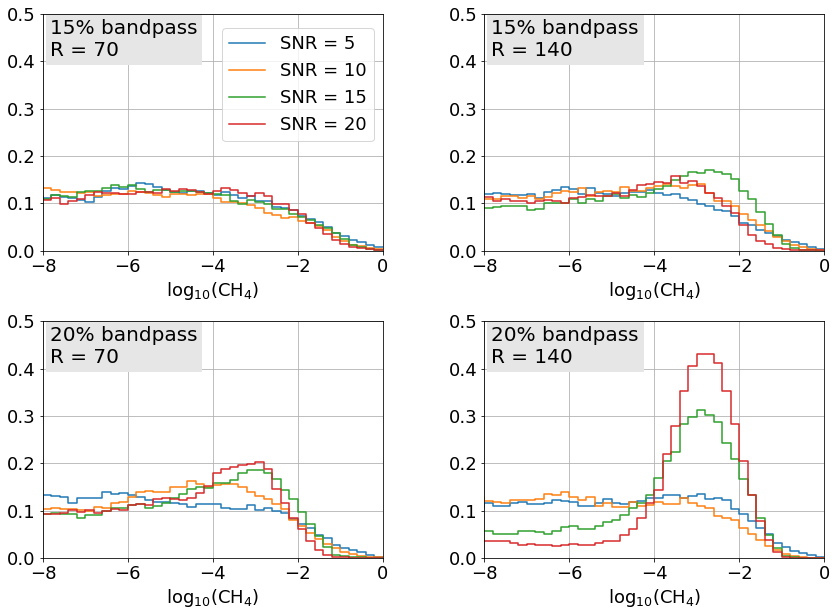

In [190]:
plt.rcParams.update({'font.size': 18})
fig,[[ax1,ax2],[ax3, ax4]] = plt.subplots(2,2,figsize=[14,10])
fig.patch.set_facecolor("w")

species = "CH4"
label = "CH$_4$"

low = -8
high = 0

upper = .5

for s in snr_1:
    ax1.step(sol[0.15][70][s][species]['edges'][1:],sol[0.15][70][s][species]['hist'],where='pre',label="SNR = "+str(s))
ax1.set_ylim(0,upper)
ax1.set_xlim(low,high)
ax1.set_xlabel('log$_{10}$('+label+')')
ax1.grid()
ax1.legend(ncol=1,bbox_to_anchor=(1,0.98),loc='upper right')
ax1.text(0.02, 0.98, '15% bandpass\nR = 70', \
        size = 20, ha='left', va='top',transform=ax1.transAxes,color='k',backgroundcolor='.9')

for s in snr_1:
    ax2.step(sol[0.15][70][s][species]['edges'][1:],sol[0.15][140][s][species]['hist'],where='pre')
ax2.set_ylim(0,upper)
ax2.set_xlim(low,high)
ax2.set_xlabel('log$_{10}$('+label+')')
ax2.grid()
ax2.text(0.02, 0.98, '15% bandpass\nR = 140', \
        size = 20, ha='left', va='top',transform=ax2.transAxes,color='k',backgroundcolor='.9')

for s in snr_1:
    ax3.step(sol[0.15][70][s][species]['edges'][1:],sol[0.20][70][s][species]['hist'],where='pre')
ax3.set_ylim(0,upper)
ax3.set_xlim(low,high)
ax3.set_xlabel('log$_{10}$('+label+')')
ax3.grid()
ax3.text(0.02, 0.98, '20% bandpass\nR = 70', \
        size = 20, ha='left', va='top',transform=ax3.transAxes,color='k',backgroundcolor='.9')

for s in snr_1:
    ax4.step(sol[0.15][70][s][species]['edges'][1:],sol[0.20][140][s][species]['hist'],where='pre')
ax4.set_ylim(0,upper)
ax4.set_xlim(low,high)
ax4.set_xlabel('log$_{10}$('+label+')')
ax4.grid()
ax4.text(0.02, 0.98, '20% bandpass\nR = 140', \
        size = 20, ha='left', va='top',transform=ax4.transAxes,color='k',backgroundcolor='.9')

plt.subplots_adjust(wspace=.3,hspace=.3)

# plt.savefig('figures/CH4.pdf',bbox_inches='tight')
plt.show()

In [184]:
10**.75

5.623413251903491

In [149]:
sol[0.15][70][5]['g']['edges'][1:]

array([0.04661062, 0.09320773, 0.13980485, 0.18640197, 0.23299909,
       0.2795962 , 0.32619332, 0.37279044, 0.41938756, 0.46598468,
       0.51258179, 0.55917891, 0.60577603, 0.65237315, 0.69897027,
       0.74556738, 0.7921645 , 0.83876162, 0.88535874, 0.93195586,
       0.97855297, 1.02515009, 1.07174721, 1.11834433, 1.16494144,
       1.21153856, 1.25813568, 1.3047328 , 1.35132992, 1.39792703])

In [41]:
i = 3
print(B[i], res[i], snr[i])
file = get_filenames(root_outdir, prefix, B[i], res[i], snr[i])
with h5py.File(file, 'r') as f:
    chain = f['mcmc']['chain'][:,:,:]
    
nburn = 1000
chain = chain[nburn:,:,:]
chain = chain.reshape(chain.shape[0]*chain.shape[1],chain.shape[2])

edges = np.arange(-10,0.1,0.2)
hist, bin_edges = np.histogram(chain[:,LCH4], bins=edges, density=True)

0.15 70 20


0.52587125


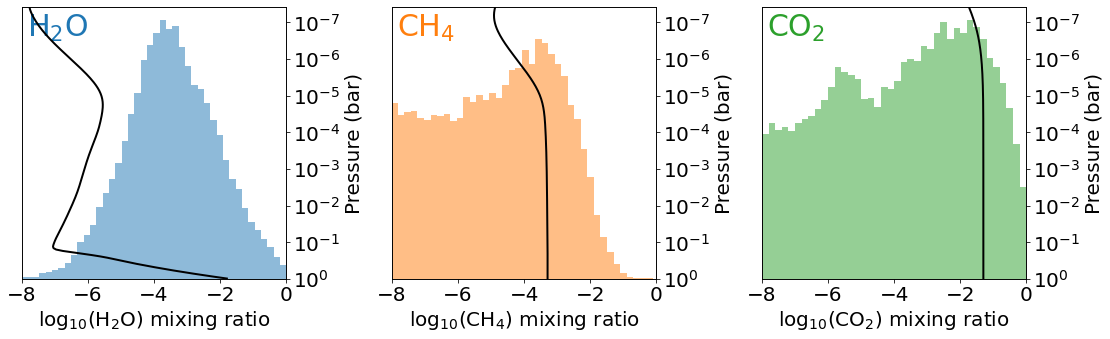

In [13]:
plt.rcParams.update({'font.size': 20})
fig,[ax1,ax2,ax3] = plt.subplots(1,3,figsize=[18,5])
fig.patch.set_facecolor("w")

ax1.hist(chain[:,LH2O], 50, density=True, color='C0', alpha=.5)
# ax1.axvline(H2O_T, c='k', lw=2)
ax1.set_yticks([])
ax1.set_xlim(-8,0)
ax1.set_xlabel('log$_{10}$(H$_2$O) mixing ratio')
ax1.text(0.02, .98, 'H$_2$O', \
        size = 30, ha='left', va='top',transform=ax1.transAxes,color='C0')

ax11 = ax1.twinx()
ax11.plot(atm['H2O'],atm['pressure'],'k',lw=2)
ax11.invert_yaxis()
ax11.set_yscale('log')
ax11.set_ylim(max(atm['pressure']),min(atm['pressure']))
ax11.set_yticks(10.0**np.array([0,-1,-2,-3,-4,-5,-6,-7]))
ax11.set_ylabel('Pressure (bar)')

# np.quantile(chain[:,LCH4],[0.16,0.5,0.84])

ax2.hist(chain[:,LCH4], 50, density=True, color='C1', alpha=.5)
# ax2.axvline(CH4_T, c='k', lw=2)
ax2.set_yticks([])
ax2.set_xlim(-8,0)
ax2.set_xlabel('log$_{10}$(CH$_4$) mixing ratio')
ax2.text(0.02, .98, 'CH$_4$', \
        size = 30, ha='left', va='top',transform=ax2.transAxes,color='C1')

ax22 = ax2.twinx()
ax22.plot(atm['CH4'],atm['pressure'],'k',lw=2)
ax22.invert_yaxis()
ax22.set_yscale('log')
ax22.set_ylim(max(atm['pressure']),min(atm['pressure']))
ax22.set_yticks(10.0**np.array([0,-1,-2,-3,-4,-5,-6,-7]))
ax22.set_ylabel('Pressure (bar)')

ax3.hist(chain[:,LCO2], 50, density=True, color='C2', alpha=.5)
# ax3.axvline(CO2_T, c='k', lw=2)
ax3.set_yticks([])
ax3.set_xlim(-8,0)
ax3.set_xlabel('log$_{10}$(CO$_2$) mixing ratio')
ax3.text(0.02, .98, 'CO$_2$', \
        size = 30, ha='left', va='top',transform=ax3.transAxes,color='C2')

ax33 = ax3.twinx()
ax33.plot(atm['CO2'],atm['pressure'],'k',lw=2)
ax33.invert_yaxis()
ax33.set_yscale('log')
ax33.set_ylim(max(atm['pressure']),min(atm['pressure']))
ax33.set_yticks(10.0**np.array([0,-1,-2,-3,-4,-5,-6,-7]))
ax33.set_ylabel('Pressure (bar)')

plt.subplots_adjust(wspace=.4)

print(len(np.where(chain[:,LCH4]>-6)[0])/len(chain[:,LCH4]))

# plt.savefig('plotting/retrieval_part.pdf',bbox_inches='tight')

plt.show()